# ODE integration with adaptive time stepping.

Vijay Varma (Albert-Einstein-Institute).  
Prepared for the Computational Physics IMPRS Course (2022).

Demonstrate ODE integration with adaptive time stepping.

In [1]:
import sys
import os
import math
import numpy as np
import scipy
from scipy.integrate import solve_ivp
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Setup the RHS, the exact solution, and plotting utils

In [2]:
def func(t, y):
    """ This function returns the RHS of the differential equation 
    dy/dt = func(t, y), for which the solution is y = exact_sol(t) below.
    """
    return 3/100 * t**3 * np.cos(1/100 * t**3) + np.sin(1/100 * t**3)

def exact_sol(t):
    """ Exact solution for a test case, chosen because that it has 
    varying amplitude and time scales. In particular the ampltude grows
    proportinally to t, while the frequency grows proportionally to t**2.
    """
    Amp = t                      # Amplitude
    omega = 1/100 * t**2         # Frequency (rad/s)
    return Amp * np.sin(omega * t)

def plot_benchmark_line(h_vec, err_vec, order=None):
    """ Plots a line with a fixed slope in a log-log plot.
        Used to show the expected scaling for an ODE solver.
    """
    # Expected scaling for the error for a method of a given order.
    # Note that the local error scales as h**(order+1), but the global
    # error scales as h**order.
    data = h_vec**order             
    data *= err_vec[-1]/data[-1]    # Normalize to match the prefactor
    plt.loglog(h_vec, data, ls='--', label=f'$h^{order}$')

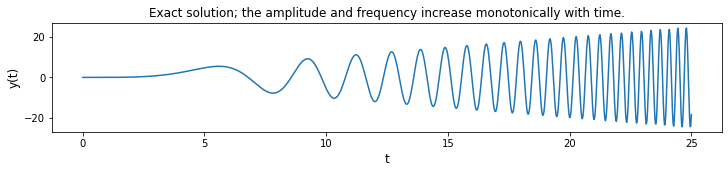

In [3]:
# Let's examine what the problem looks like
t_tmp = np.linspace(0, 25, 1000)
plt.figure(0, figsize=(12, 2))
plt.plot(t_tmp, exact_sol(t_tmp))
plt.xlabel('t', fontsize=12)
plt.ylabel('y(t)', fontsize=12)
plt.title('Exact solution; the amplitude and frequency increase monotonically with time.', fontsize=12);

## Setup ODE options

In [4]:
# ODE method to use. 
# DOP853 is an 8th order RK method with adaptive time stepping (the 
# error is estimated effectively at 8th order by combining embedded 
# 5th and 3rd order estimates.) 
# See Chapter 17, Sec 2.4 of Numerical Recipes (3d Edition). Also see 
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html
# for other options.
method = 'DOP853'   

t0 = 0                   # Start time
tmax = 25                # End time
y0 = exact_sol(t0)       # initial value

# We will try to get a solution with error below this tolerance. 
# Initially, we will use fixed time steps, where we have to try various
# time steps and pick an optimal one.
# Later on, we will use adaptive time steps, where this is done
# automatically in real time.
target_tol = 1e-7

## Experiment with fixed time step

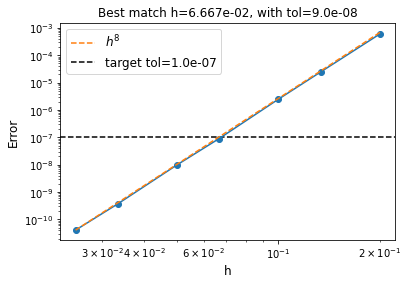

In [5]:
# List of fixed time steps to try to achieve the above target_tol
h_vec = 0.2 * np.array([1, 1/1.5, 1/2, 1/3, 1/4, 1/6, 1/8])
err_vec = []

# Loop over different fixed time steps and solve the ODE
for h0 in h_vec:
    # NOTE: By setting rtol=atol=1 and max_step=h, 
    # we trick solve_ivp to always use a fixed time step. 
    # This is wasteful, but we have a point to prove.
    sol = solve_ivp(func, [t0, tmax], [y0], rtol=1, atol=1, 
                    max_step=h0, method=method)
    t = sol.t
    y = sol.y[0]
    
    # Compute global error
    err_vec.append(np.max(np.abs(y - exact_sol(t))))
err_vec = np.array(err_vec)

## Sanity check that the global error scales properly
plt.loglog(h_vec, err_vec, marker='o')
# The expected sclaing: RK8 has local error of order 9, 
# and therefore a global error of order 8.
plot_benchmark_line(h_vec, err_vec, order=8)

# Find the h for which we are closest to target_tol
best_idx = np.argmin(np.abs(err_vec - target_tol))
h_best = h_vec[best_idx]

# Convergence plot to make sure the error scales as expected.
plt.xlabel('h', fontsize=12)
plt.ylabel('Error', fontsize=12)
plt.axhline(target_tol, ls='dashed', color='k', 
            label=f'target tol={target_tol:.1e}', zorder=-1)
plt.title(label=f'Best match h={h_best:.3e}, '
          f'with tol={err_vec[best_idx]:.1e}')
plt.legend(fontsize=12);

### Demonstrate the wastefulness of fixed time steps

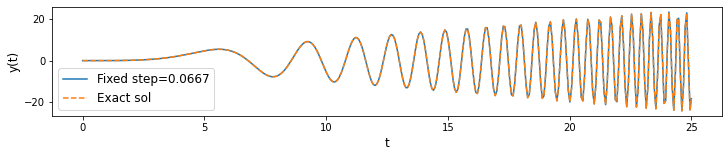

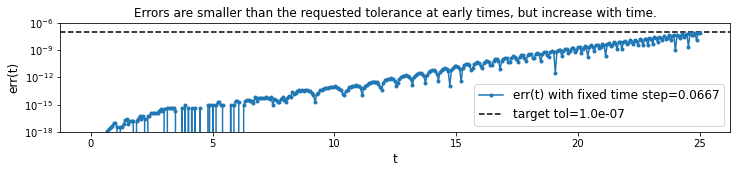

In [6]:
# Recompute and examine solution with fixed step size h=h_best.
sol = solve_ivp(func, [t0, tmax], [y0], rtol=1, atol=1, 
                max_step=h_best, method=method)
t_fixed = sol.t
y_fixed = sol.y[0]

# ODE solution vs exact solution: we have good agreement.
# Notice that both amplitude and frequency increase 
# with time (as intended).
plt.figure(0, figsize=(12, 2))
plt.plot(t_fixed, y_fixed, label=f'Fixed step={h_best:.4f}')
plt.plot(t_fixed, exact_sol(t_fixed), ls='dashed', label='Exact sol')
plt.legend(fontsize=12, loc='best')
plt.xlabel('t', fontsize=12)
plt.ylabel('y(t)', fontsize=12)

# Now consider the error as a function of time.
# At early times the errors are well below threshold (target_tol), 
# and the time steps are wastefully small. At late times, the error
# becomes larger as the solution evolves faster and increases in 
# amplitude. Ideally, we want to increase the time steps in the 
# early part, which we will do below.
plt.figure(1, figsize=(12, 2))
err_fixed = np.abs(y_fixed - exact_sol(t_fixed))
plt.semilogy(t_fixed, err_fixed, marker='.', 
             label=f'err(t) with fixed time step={h_best:.4f}')
plt.axhline(target_tol, ls='dashed', color='k', 
            label=f'target tol={target_tol:.1e}', zorder=-1)
plt.xlabel('t', fontsize=12)
plt.ylabel('err(t)', fontsize=12)
plt.legend(fontsize=12, loc='lower right')
plt.title('Errors are smaller than the requested tolerance at '
          'early times, but increase with time.')
plt.ylim(1e-18, 1e-6);

## Adaptive time stepping

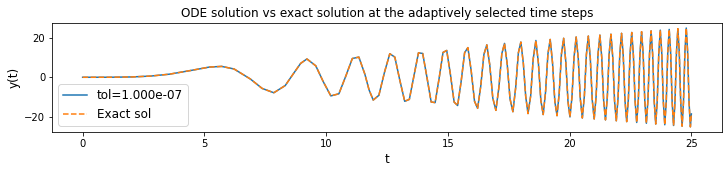

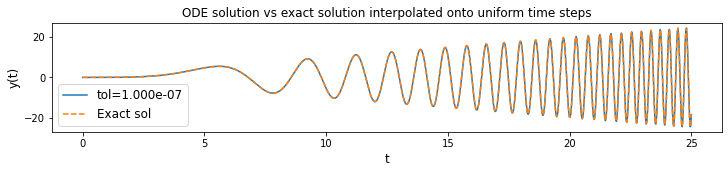

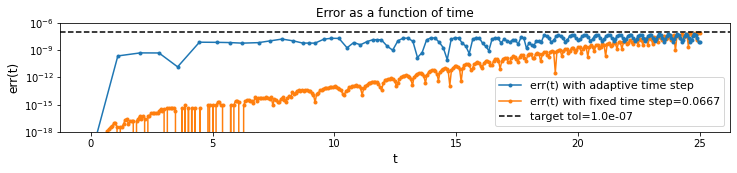

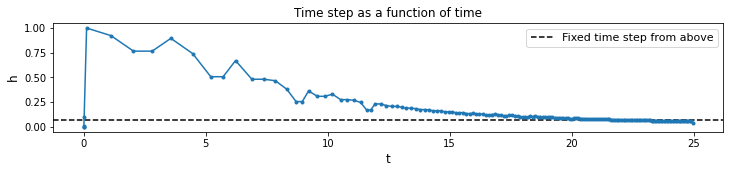

In [7]:
# Now solve the same problem with an adaptize step size, at the given 
# tolernace. Notice that we now use dense_output so that we can 
# interpolate the solution to any desired time array
sol = solve_ivp(func, [t0, tmax], [y0], atol=target_tol, rtol=target_tol,
                dense_output=True, method=method)
t_adaptive = sol.t
y_adaptive = sol.y[0]

# ODE solution with adaptive times steps vs the exact solution.
# Notice that the solution is a bit jagged because there are fewer 
# time steps. But this is a good thing!
plt.figure(0, figsize=(12, 2))
plt.plot(t_adaptive, y_adaptive, label=f'tol={target_tol:.3e}')
plt.plot(t_adaptive, exact_sol(t_adaptive), ls='dashed', label='Exact sol')
plt.legend(fontsize=12, loc='lower left')
plt.xlabel('t', fontsize=12)
plt.ylabel('y(t)', fontsize=12)
plt.title('ODE solution vs exact solution at the adaptively '
          'selected time steps')

# You can get a smooth solution by simply interpolating, as we see 
# below. Internally, the interpoltion method is of comparable order 
# to the ODE stepper.
t_interp = np.linspace(t0, tmax, 1000)
y_interp = sol.sol(t_interp)[0]
plt.figure(1, figsize=(12, 2))
plt.plot(t_interp, y_interp, label=f'tol={target_tol:.3e}')
plt.plot(t_interp, exact_sol(t_interp), ls='dashed', label='Exact sol')
plt.legend(fontsize=12, loc='lower left')
plt.xlabel('t', fontsize=12)
plt.ylabel('y(t)', fontsize=12)
plt.title('ODE solution vs exact solution interpolated onto '
          'uniform time steps')


# Now let's consider what the error looks like as a function of time.
# The error is below the target tolerance, but the error control is 
# not perfect. Even so, we can get a similar accuracy with much fewer
# time steps as we will see below.
plt.figure(2, figsize=(12, 2))
err_adaptive = np.abs(y_adaptive - exact_sol(t_adaptive))
plt.semilogy(t_adaptive, err_adaptive, marker='.', 
             label='err(t) with adaptive time step')
plt.semilogy(t_fixed, err_fixed, marker='.', 
             label=f'err(t) with fixed time step={h_best:.4f}', zorder=-1)
plt.axhline(target_tol, ls='dashed', color='k', 
            label=f'target tol={target_tol:.1e}', zorder=-1)
plt.ylim(1e-18, 1e-6)
plt.xlabel('t', fontsize=12)
plt.ylabel('err(t)', fontsize=12)
plt.legend(fontsize=11, loc='lower right')
plt.title('Error as a function of time')

# How does the time step change?
# Notice that we start with big time steps in the slowly varying part
# of the solution, and take progressively smaller steps as we approach
# the fastly varying part.
plt.figure(3, figsize=(12, 2))
plt.plot(t_adaptive[:-1], np.diff(t_adaptive), marker='.')
plt.axhline(h_best, ls='dashed', color='k', 
            label=f'Fixed time step from above', zorder=-1)
plt.xlabel('t', fontsize=12)
plt.ylabel('h', fontsize=12)
plt.legend(fontsize=11, loc='upper right')
plt.title('Time step as a function of time');


In [8]:
# What did we gain? 
# Let's look at the number of time steps for fixed and adaptive time
# step methods.
print (f'Number of time steps with fixed h is {len(t_fixed)}, '
       f'and with adaptive h is {len(t_adaptive)}.')
# How different were the global errors?
print (f'Global error for fixed h is {np.max(err_fixed):.2e}, '
       f'and for adaprive h is {np.max(err_adaptive):.2e}, '
       f'for target_tol={target_tol:.2e}')

Number of time steps with fixed h is 379, and with adaptive h is 164.
Global error for fixed h is 9.02e-08, and for adaprive h is 5.66e-08, for target_tol=1.00e-07
